In [1]:
from frgpascal.hardware.sampletray import Tray1, Tray2
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.experimentaldesign.helpers import build_sample_list
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign import characterizationtasks as chtsk

from frgpascal.experimentaldesign.helpers import PASCALPlanner

------

# Define hardware for this experiment

## Liquid Labware 

Include _all possible_ liquid storage + pipette tipracks. Later on we will narrow this down to what is required once we know what solutions and volumes we need.

Versions are defined by the same json files used to define custom labware for the Opentrons2 liquid handler. 
New labware can be defined by following https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions

The location of the labware/tiprack on the opentrons deck must be specified as well.


| Deck | Slot | Layout |
| ----------- | ----------- | ----------- |
| 10      | 11       | _Trash_ |
| 7   | 8        | 9 |
|4 | 5 | 6|
|1 | _Spin_ | _Coater_|


For partially consumed tip racks, the `starting_tip` argument can be used to specify the first available tip. Tips before this assumed to be used up. (moves down->right, like A1, B1...H1, A2, B2 etc). If this argument is omitted, we assume to start at tip A1

In [2]:
print('\nAvailable Liquid Labwares:')
for v in liquid_labware_versions:
    print(f'\t{v}')


Available Liquid Labwares:
	frg_12_wellplate_15000ul
	sartorius_safetyspace_tiprack_200ul
	greiner_96_wellplate_360ul
	frg_spincoater_v1
	perkinelmer_p235_tiprack_235ul
	frg_24_wellplate_4000ul


In [3]:
tipracks = [
    TipRack(
        version='perkinelmer_p235_tiprack_235ul', 
        deck_slot=8, #which slot on the deck the tiprack is in
        starting_tip="F2" #starting tip, to skip consumed tips
    ),
    # TipRack(
    #     version='perkinelmer_p235_tiprack_235ul', 
    #     deck_slot=11,
    #     starting_tip="B1"
    # ),
    ]

the `starting_well` argument can be used to similarly specify the first available well on the tray. This is useful for mixing on partially used well plates. Note that the use order of wells differs from tips (moves right->down, like A1, A2,...A12, B1, B2 etc)

In [4]:
tray4ml = LiquidLabware(
    name='4mL_Tray1',
    version='frg_24_wellplate_4000ul',
    deck_slot=6
    )
plate96 = LiquidLabware(
    name="96wellplate",
    version="greiner_96_wellplate_360ul",
    deck_slot=5
)
tray15ml = LiquidLabware(
    name="15mL_Tray1",
    version="frg_12_wellplate_15000ul",
    deck_slot=4
)

-----

# Define Experimental Mesh

Each of the following sections defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed.

## Solutions to spincast. 

Solutions are defined using `Solution` class instances.

Chemical formula is defined with underscores between each component. If no coefficient is provided, assumes =1. Example:

``` 
SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```
Note that you can use parentheses to simplify the formulae.
``` 
SolutionRecipe(
        solutes='MA_Pb_(I0.8_Br0.2)3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```

Antisolvents are also defined using `Solution` class instances. Solutes are left empty, and molarity is unused so can be left as 1/whatever number you like.

Example:
``` 
Solution(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    )
```

Solutions that will be interchanged (for example, different absorber solutions for compositional search) should be stored in a list. This list will be used later to permute sample process variables


In [5]:
absorber_solution = Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.15_Cl0.05)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.2,
        alias="Absorber" #optional, just makes output easier to read
   )
tray4ml.load(absorber_solution, 'A1') #load the absorber solution into the first well of the 4mL vial tray

'A1'

In [6]:
methyl_acetate = Solution(
        solvent='MethylAcetate', #no solutes/molarity required if this Solution is just solvent
    )
tray4ml.load(methyl_acetate, 'D1')

'D1'

In [7]:
htl = Solution(
    solutes='MEO-2PAcZ',
    solvent='IPA',
    molarity=0.6, 
    )
tray4ml.load(htl, 'B3')


'B3'

In [8]:
etl_pcbm = Solution(
    solutes='PCBM',
    solvent='Chlorobenzene',
    molarity=30, #mg/mL
)
tray4ml.load(etl_pcbm, 'C2')


'C2'

## Annealing Conditions
Annealing conditions are defined as a list of `AnnealRecipe` class instances. Only two parameters - temperature (C) and duration (s)

Example:
``` 
    AnnealRecipe(
        temperature=100, #degrees C
        duration=60*60, #seconds
    ),
```

In [9]:
anneal_absorber = Anneal(
    temperature=100,
    duration=30*60, #30 minutes
)

anneal_htl = Anneal(
    temperature=100,
    duration=10*60, #10 minutes
)

anneal_pcbm = Anneal(
    temperature=100,
    duration=5*60, #5 minutes
)


## Spincoating Recipes


Spincoating recipes are defined using the `Spincoat` object. This takes two arguments: `steps`,a nested list of [speed, acceleration, duration] spin steps, and `drops`, a list of `Drop` objects that capture the details of each solution drop during spincoating. 

```
Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops=[
            Drop(
                solution=target_solutions[0],
                volume=20, # uL
                time=5, # seconds from start of spincoating
                height=2, # mm above substrate to dispense from, optional
                rate=50, # dispense rate (uL/sec), optional
                pre_mix=3, #number of sequential aspirate->dispense cycles to mix solution prior to aspiration, optional
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=30,
                reuse_tip=True #whether to reuse this pipette tip (only uses tips previously used for the same solution.)
            )
        ]
    )
```

often we will be using many solutions with the same spincoating recipe. In these cases, the `solution` argument of a `Drop` object can just be a string. This string can be substituted by a list of solutions at the final step. Example:

```
spincoat_recipes = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution', # we will fill any Drop solutions labeled as 'psk_solution' later
                volume=20,
                time=5,
                pre_mix=3,
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=40,
                reuse_tip=True,
            )
        ]
    ),
```

#### Defining spincoating parameters

In [10]:
spincoat_absorber_lowvolume = Spincoat(
        steps=[
            [1000,200,5], #speed (rpm), acceleration (rpm/s), duration (s)
            [5000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=40,
                time=-1,
                blow_out=True
            ),
            Drop(
                solution=methyl_acetate,
                volume=80,
                time=28,
                reuse_tip=True,
                touch_tip=False,
                rate=80,
                pre_mix=(3,100),
                slow_travel=True,
                blow_out=False
            )
        ],
        immediate=True
    )

In [11]:
spincoat_htl = Spincoat(
        steps = [
            [5000,500,30], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=htl,
                volume=30,
                time=-5,
                reuse_tip = True,
                blow_out=True,
                pre_mix = (3,100)
            )
        ],
        # immediate=True
    )

In [12]:
rpm_sqrts = np.linspace(np.sqrt(1000), np.sqrt(5000), 7)
rpms = rpm_sqrts**2

spincoat_etl_sweep = [
    Spincoat(
        steps = [
            [rpm,1000,40], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=etl_pcbm,
                volume=20,
                time=2,
                pre_mix = (3,100)
            )
        ]
    )
    for rpm in rpms]

spincoat_etl_1krpm = Spincoat(
        steps = [
            [1000,1000,40], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=etl_pcbm,
                volume=20,
                time=2,
                pre_mix = (3,100)
            )
        ]
    )

## Characterization Tasks

Sample characterization is defined using a `Characterize` instance. This takes an argument `tasks`, which is a list of `CharacterizationTask` instances defining the measurement types and parameters. The tasks will execute in the order they are listed, unless a second argument `reorder_by_position` is set to `True`, in which case the tasks will be reordered to minimize travel distance along the characterization stage axis.

Available `CharacterizationTask`s:
- `Brightfield`: a brightfield image of the entire sample
- `Darkfield`: a darkfield image of the center of the sample
- `PLImagining`: a photoluminescence intensity image of the same center region of the sample
- `TransmissionSpectroscopy`: transmittance measurement through the center of the sample
- `PLSpectroscopy`: photoluminescence spectra from the center of the sample, excitation source = 0.1 suns 635 nm laser
- `PLPhotostability`: continuous PL spectra from the center of the sample over extended exposure, excitation source = 4 suns 405 nm laser

In [13]:
char_absorber = Characterize(
    tasks = [
        chtsk.Brightfield(),
        # chtsk.PLPhotostability(
        #     exposure_time = 0.2, #acquisition time (s) of each individual spectrum
        #     duration=30        #duration (s) to record spectra
        # ),
        chtsk.PLSpectroscopy(
            exposure_times=[1, 5, 20], #acquisition time (s) of each individual spectrum. The longest time that does not saturate the detector will be used
            num_scans=1 #number of scans to average
        ),
        chtsk.TransmissionSpectroscopy(),
        chtsk.Darkfield(),
        chtsk.PLImaging(
            num_frames=10, #number of images to average
        )
    ]
)

-----

# Design of Experiment

We will input all the values defined above into `build_sample_list` to generate a sample list. Currently only a full-factorial design is implemented. 
The arguments for `build_sample_list` are as follows:
- `input_substrates`: list of substrates (strings) describing the unique starting substrates
- `steps`: worklist of process steps (`Spincoat`, `Anneal`, `Rest`, or `Characterize`) **in desired order of completion**. Each of the list elements can be a single step (if the step does not change across samples), or a list of steps of the same kind (for example, a list of spincoat variations)
- `solution_mesh`: a dictionary used to fill in solution placeholders in `Drop` objects. Keys should match the placeholder strings, and values should be lists of `Solution` objects to put into the `Drop` object.
- `n_repeats`: number of duplicates to run for each unique worklist

arguments are lists defined above, and n_repeats is the number of times to repeat each unique combination of conditions

In [14]:
samples_cells = build_sample_list(
    input_substrates = ['FTO'],
    steps = [
        spincoat_htl,
        # anneal_htl,
        # Rest(60),
        spincoat_absorber_lowvolume, 
        anneal_absorber, 
        Rest(180), 
        char_absorber,
        spincoat_etl_sweep,
        anneal_htl
    ],
    n_repeats=2,
)
samples_forevapetl = build_sample_list(
    input_substrates = ['FTO'],
    steps = [
        spincoat_htl,
        # anneal_htl,
        # Rest(60),
        spincoat_absorber_lowvolume, 
        anneal_absorber, 
        Rest(180), 
        char_absorber
    ],
    n_repeats=15,
)

allsamples = samples_cells + samples_forevapetl

/Users/rishi/GitHub/PASCAL/frgpascal/experimentaldesign/helpers.py:234: UserWarning: Back to back Spincoat and Characterization is ok, but can seriously rate limit the experiment (both have single substrate capacity). Consider inserting a Rest step if you can tolerate it.
  warnings.warn(


## Define Stock Solutions

These are the solutions that you will be mixing to (hopefully) cover your target solutions. If they don't work, the code will tell you, and you can come back to this point and try again.

In [15]:
planner = PASCALPlanner(
    name='experiment name',
    description='detailed description of the experiment',
    operator='your name',
    samples=allsamples,
    sample_trays=[
        Tray1(), 
        # Tray2()
    ], #list of storage trays available to hold samples
    tip_racks = tipracks, #list of pipette tipracks available to the liquid handler
    solution_storage = [
        tray4ml,
    ], #list of solution storage objects available to the liquid handler
    stock_solutions = [
        absorber_solution,
        htl,
        etl_pcbm,
        methyl_acetate
    ], #list of stock solutions that the user loads into the liquid handler
)

In [16]:
planner.process_solutions(
    min_volume = 50, # extra volume (uL) to add for each solution
    strategy = 'prefer_stock' #prefer_stock or least_inputs
)

===== Stock Prep =====
330.00 of 30M PCBM in Chlorobenzene
920.00 of 0.6M MEO-2_PAcZ in IPA
1210.00 of Absorber
2370.00 of MethylAcetate


Solving intermediate schedule up to breakpoint 0
	solution status: OPTIMAL
Solving final schedule
	solution status: FEASIBLE
schedule image saved to "schedule_experiment name.jpeg"


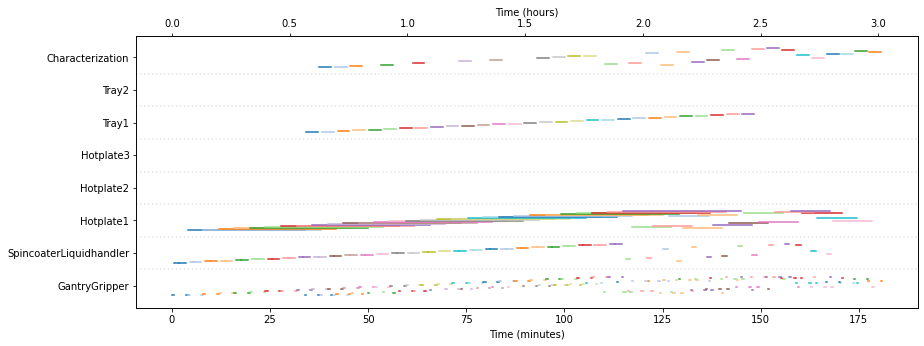

In [17]:
planner.solve_schedule(
    shuffle=True, #randomize process order
    solve_time = 10, #time (s) to spend finding a solution. 
    prioritize_first_spincoat= True #prioritize first spincoat step, useful to preserve UVO surface treatment.
)

OT2 protocol dumped to "./OT2PASCALProtocol_experiment name.py"
Maestro Netlist dumped to "maestronetlist_experiment name.json"
Sample dataframe dumped to "sampledataframe_experiment name.csv"


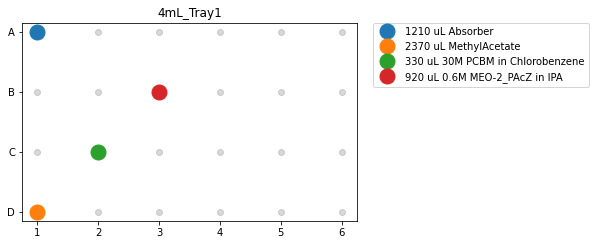

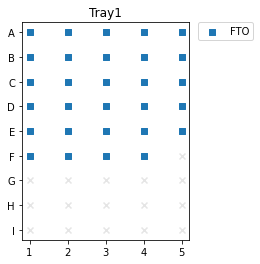

In [19]:
planner.export()

-----

## Commands beyond here should be executed on the PASCAL command prompt

### After starting the PASCAL program, a command prompt will open with some objects pre initialized. Important ones are:
- m = `frgpascal.maestro.Maestro`
- cl = `frgpascal.hardware.characterizationline.CharacterizationLine`



### Then run the following code
This command load the tasks and start heating up hotplates

`>> m.load_netlist("path/to/maestronetlistfile.json")`

You should now close the curtain and turn off the light in the glovebox. The following command take baselines for the spectroscopies.

`>> cl.take_baseline("path/to/maestronetlistfile.json")`

Finally, you can run this command to execute the experiment. It will trigger a checklist. If you pass the checklist, the experiment will begin!

`>> m.run("opentrons ip address")`
